In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import shutil
import torch
import torch.nn as nn
import torch.utils.data
import h5py
from torch.autograd import Variable
import time
from tqdm import tqdm
import model_wavefront as model
import argparse
import glob
import platform
import os
import astropy.units as u
import wavefront as wf
from IPython.display import Image
from IPython.core.display import HTML 
from ipywidgets import interact_manual
import ipywidgets as widgets
import pandas as pd

# Real-time wavefront sensing with phase diversity
In this brief note I consider a proof-of-concept of how to carry out online wavefront sensing using two cameras, one located at the focus of the instrument and the other one located slightly defocused. This is a somehow standard way to obtain the wavefront but suffers from computational problems. The reason is that one needs to solve a complex optimization problem which is computationally intensive.

Since we all know how phase diversity works, I'll only briefly descript the method and mainly focus on how to accelerate it and find the wavefront in real time. In the linear theory of image formation the discrete image arriving at the detector after having being affected by the atmosphere and all the optical elements of the telescope and instrument, $\mathbf{i}$, is obtained from the image without perturbation, $\mathbf{o}$, by computing

\begin{equation}
\mathbf{i} = \mathbf{h} * \mathbf{o} + \mathbf{n}
\end{equation}

where $\mathbf{h}$ is the point spread function (PSF) of the whole system and $\mathbf{n}$ is a noise vector with some known statistics. The PSF can be written as the square modulus of the Fourier transform of the complex amplitude in the aperture of the telescope:

\begin{equation}
\mathbf{h} = |\mathcal{F}\left( \mathcal{P} e^{\phi} \right) |^2,
\end{equation}
where $\mathcal{P}$ is the modulus of the amplitude which, for a perfect telescope, is constant inside the pupil of the telescope and zero otherwise. $\phi$ is the phase of the wavefront, which are produced by differences in the optical path in the atmosphere due to the turbulence, as well as by aberrations in the optical systems.
In the following, we describe the wavefront as a linear commbination of Zernike polynomials, which are orthogonal functions in the unit circle (other functions like Karhunen-Loeve modes are probably desirable in more realistic situations):

\begin{equation}
\phi = \sum_{j=4}^N a_j Z_j(x,y),
\end{equation}
where $(x,y)$ are coordinates in the pupil plane. We start the summation in index 4 (Noll indices) because we neglect the piston, tip and tilts.

In the standard phase-diversity scheme, one obtains an image at focus and another one with a known defocus. Therefore, the two images are given by:

\begin{align}
\mathbf{i}_\mathrm{focus} &= \mathbf{h}(\phi) * \mathbf{o} + \mathbf{n}_1 \\
\mathbf{i}_\mathrm{defocus} &= \mathbf{h}(\phi+\Delta \phi) * \mathbf{o} + \mathbf{n}_2,
\end{align}
where we make explicit the dependence of the PSF on the wavefront. $\Delta \phi$ is the defocus introduced in the second camera, which can be easily described in the Zernike basis as $\Delta \phi=\delta a_4 Z_4$. The previous problem is routinely solved by writing the likelihood associated with the statistics of the noise and maximizing it. In the case of Gaussian noise, the log-likelihood function is given by:

\begin{equation}
\log L = \lVert  \mathbf{i}_\mathrm{focus} - \mathbf{h}(\phi) * \mathbf{o} \rVert^2 + \lVert \mathbf{i}_\mathrm{defocus} - \mathbf{h}(\phi+\Delta \phi) * \mathbf{o} \rVert^2.
\end{equation}
This likelihood can be optimized using an alternatinv optimization method for the wavefront and the image $\mathbf{o}$. When the wavefront is considered to be known, the solution for the object can be obtained in closed form. On the contrary, when the object is assumed to be known, the solution to the wavefront is not given in closed form and one can iterate the two solutions until a full solution is found. The main message is that obtaining the wavefront and the image in phase diversity techniques requires the solution of a nonlinear problem, which is computationally heavy.

We proposed here to fully bypass the optimization process leveraging a deep neural network that directly extracts the wavefront from the couple of focus+defocus images. Initially, I started training the network in a supervised way by optimizing the loss function computed from the Zernike modes of the wavefront from each pair of images and the real Zernike modes. However, this has the problem that it completely bypasses the physics behind the image formation and the presence of the diversity in the defocused channel. Therefore, it makes much more sense to add this physics during the training. This is done by following the scheme below. 

There is an encoder that takes as input two images (in our case images of 64$\times$64 pixels) and produces as output a vector of Zernike modes. This network is a fully convolutional network with input of size 2$\times$64$\times$64 and output of size 37$\times$1$\times$1. The images are passed through successive convolutional layers in residual connection mode (some of them also contain batch normalization and LeakyReLU connections. The output is supposed to be the Zernike modes of the wavefront. Then, I compute the wavefront from these modes and compute the associated PSF. Simultaneously, I add the diversity to the wavefront and compute the defocused PSF. Then I use the original image from a simulation from which I generated the training set and apply the two PSFs, generating a new focused and defocused pair. This pair is then compared with those in the input until a good fit is obtained. Additionally, I add as a regularization the l2 distance between the generated wavefront and the original wavefront.

The general scheme is, then, as follows:

In [2]:
Image(url= "network.png")

The encoder is, as a first proposal, given by the following convolutional neural network:

In [51]:
Image(url= "cnn.png")

In principle, PD is not sensitive to phases larger than $2 \pi$, so the wavefront might suffer from wrapping. However, I hope that the fact that I'm introducing a regularization on the wavefront produces Zernike modes such that the wavefront is automatically unwrapped.

### Training
The training is done by using images from an emerging flux region simulation carried out by M. Cheung. Here is an example of such images:

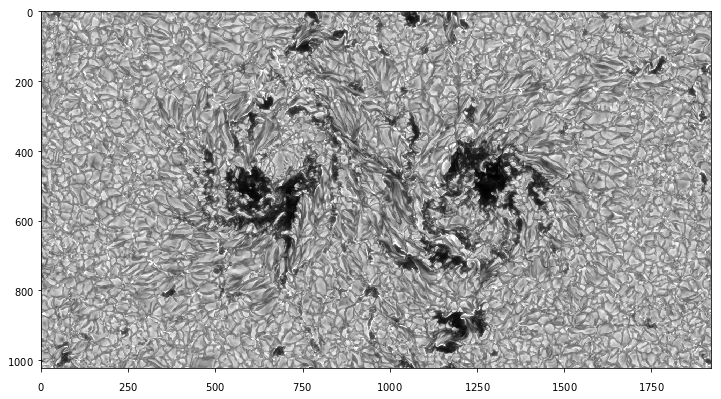

In [2]:
image = np.copy(np.memmap('/scratch1/3dcubes/cheung/quiet/I_out.064000',dtype='float32',offset=4*4,mode='r',shape=(1024,1920)))
image /= np.mean(image[0:50,0:50])
f, ax = pl.subplots(figsize=(12,8))
im = ax.imshow(np.clip(image, 0,1.5))

We extract patches randomly from these maps (of the order of 100) and apply random realization of a Kolmogorov atmosphere with Fried radius uniformly distributed between 5 and 40 cm. After applying the PSFs, we remove any residual tip-tilt by recentering the images with respect to the original image.

The training is done in PyTorch [https://pytorch.org], which allows one to define the deep neural network and our complicated loss function (that contains the generation of the wavefront, PSFs and convolution of the images) and automatically compute the necessary derivatives. Let's plot the evolution of the loss function at all epochs. I note that the network does not show any hint of overfitting but more work is needed for improving the results.

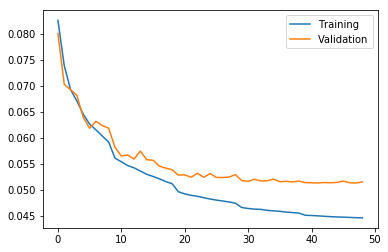

In [58]:
tmp = pd.read_csv('../training/trained_wavefront/2018-12-19-13:28.loss.csv')
f, ax = pl.subplots()
ax.plot(tmp.values[:,1], label='Training')
ax.plot(tmp.values[:,2], label='Validation')
ax.legend()

## Examples
Once the network is trained (not shown in this notebook), we define a class that contains all the machinery to generate wavefronts from the validation dataset.

In [38]:
class deep_phasediv(object):
    def __init__(self, telescope_diameter, pixel_size, lambda0, npix_psf, n_zernike, batch_size, n_testing=-1, resume=None, checkpoint=None):

        # Define all parameters for correctly carrying out the convolution with generated PSFs
        self.lambda0 = lambda0
        self.telescope_diameter = telescope_diameter
        self.pixel_size = pixel_size
        self.npix_psf = npix_psf
        self.n_zernike = n_zernike
        self.batch_size = batch_size
        self.cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.cuda else "cpu")        
        self.n_testing = n_testing


        # Compute the PSF scale appropriate for the required pixel size, wavelength and telescope diameter
        self.overfill = wf.psfScale(self.telescope_diameter, self.lambda0, self.pixel_size)

        self.nbig = int(np.ceil(self.npix_psf * self.overfill))
        if (self.nbig % 2 != 0):
            self.nbig += 1

        self.half = (self.nbig - self.npix_psf) // 2
        center = self.nbig // 2

        if (self.n_zernike != 0):
            self.zernikes = np.zeros((self.n_zernike,self.npix_psf,self.npix_psf))
            for j in range(self.n_zernike):
                self.zernikes[j,:,:] = wf.zernike(j+4,npix=self.npix_psf) 

        self.zernikes_torch = torch.zeros((self.n_zernike,self.nbig,self.nbig),dtype=torch.float32).to(self.device)

        self.zernikes_torch[:,self.half:self.half+self.npix_psf,self.half:self.half+self.npix_psf] = torch.from_numpy(self.zernikes)
        
        
        # Temporary arrays for PSF calculation and convolution
        self.wfbig = torch.zeros((self.batch_size,self.nbig,self.nbig),dtype=torch.float32).to(self.device)
        self.illum = torch.zeros((self.batch_size,self.nbig,self.nbig),dtype=torch.float32).to(self.device)
        self.phase = torch.zeros((self.batch_size,self.nbig,self.nbig,2),dtype=torch.float32).to(self.device)
        self.psf = torch.zeros((self.batch_size,self.npix_psf,self.npix_psf,2),dtype=torch.float32).to(self.device)
        self.image = torch.zeros((self.batch_size,self.npix_psf,self.npix_psf,2),dtype=torch.float32).to(self.device)
        self.prod = torch.zeros((self.batch_size,self.npix_psf,self.npix_psf,2),dtype=torch.float32).to(self.device)
        self.zernike_defocus = torch.zeros((self.batch_size,37),dtype=torch.float32).to(self.device)

        self.zeros = torch.zeros((self.batch_size, self.npix_psf, self.npix_psf, 1),dtype=torch.float32).to(self.device)

        # Defocus Zernike coefficient. It is at index 0 because we are not considering modes 1,2 and 3 (piston, tip, tilt)
        self.zernike_defocus[:,0] = 1.0 * np.pi / np.sqrt(3.0)

        # Compute telescope aperture
        self.aperture = wf.aperture(npix = self.npix_psf, cent_obs = 0, spider=0)

        # Illumination of the pupil
        self.illum[:,self.half:self.half+self.npix_psf,self.half:self.half+self.npix_psf] = torch.from_numpy(self.aperture)[None,:,:]

        # Compute mask to select the central part of the PSF, which has been computed in a larger
        # array to fit the pixel size with the spatial frequencies
        self.mask = torch.ones((self.batch_size, self.nbig, self.nbig)).byte().to(self.device)
        

        self.mask[:,center-self.half:center+self.half+1,:] = 0
        self.mask[:,:,center-self.half:center+self.half+1] = 0

        torch.backends.cudnn.benchmark = True
                                            
        kwargs = {'num_workers': 1, 'pin_memory': True} if self.cuda else {}

        telescope_radius = 0.5*1.5 * u.meter
        pixel_size = 0.0545 * u.arcsec / u.pixel
        fov = (101, 101) * u.pixel
        pix_fov = 101    
        lambda0 = 500 * u.nm

        self.model = model.network(2*telescope_radius.value, pixel_size.value, lambda0.to(u.AA).value, pix_fov, self.device, self.batch_size, 37).to(self.device)

        if (checkpoint is None):
            files = glob.glob('../training/trained_wavefront/*.pth')
            self.checkpoint = max(files, key=os.path.getctime)
            
        else:
            self.checkpoint = '{0}.pth'.format(checkpoint)

        print("=> loading checkpoint '{}'".format(self.checkpoint))
        if (self.cuda):
            checkpoint = torch.load(self.checkpoint)
        else:
            checkpoint = torch.load(self.checkpoint, map_location=lambda storage, loc: storage)
        self.model.load_state_dict(checkpoint['state_dict'])        
        print("=> loaded checkpoint '{}'".format(self.checkpoint))
        
        computer_name = platform.node()

        if (computer_name == 'Andres-Mac.local'):
            self.test_file = '/scratch/deep_learning/wavefrontPD/validation_cheung.h5'

        if (computer_name == 'vena'):
            self.test_file = '/scratch1/deepLearning/wavefrontPD/validation_cheung.h5'
        
        self.file = h5py.File(self.test_file, 'r')
        self.n_images, _, self.nx, self.ny = self.file['images'].shape
        _, self.zernike = self.file['wavefront'].shape
                                
    def get_psf_wavefront(self, zernike):
        
        # Compute wavefront by summing over Zernike polynomials
        wavefront = torch.sum(zernike[:,:,None,None] * self.zernikes_torch, 1)

        # Compute real and imaginary parts of the pupil
        tmp1 = torch.unsqueeze(torch.cos(wavefront) * self.illum, -1)
        tmp2 = torch.unsqueeze(torch.sin(wavefront) * self.illum, -1)

        self.phase = torch.cat([tmp1, tmp2], -1)

        # Compute FFT of the pupil function and compute autocorrelation
        ft = torch.fft(self.phase, 2)
        psf = ft[:,:,:,0]**2 + ft[:,:,:,1]**2

        # Extract the central part of the PSF of the size of the image
        psf = psf[self.mask].view((self.batch_size, self.npix_psf, self.npix_psf))
        return wavefront, psf
            
    def plot(self, index=None):
        self.model.eval()
        
        if (index is None):
            index = np.random.randint(self.n_images)
        
        im_focus_defocus = self.file['images'][index:index+2,1:,:,:]
        im_focus_defocus += np.random.normal(loc=0.0, scale=1e-4, size=im_focus_defocus.shape)

        minim = np.min(im_focus_defocus, axis=(2,3))
        maxim = np.max(im_focus_defocus, axis=(2,3))

        im_focus_defocus = (im_focus_defocus - minim[:,:,None,None]) / (maxim[:,:,None,None] - minim[:,:,None,None])

        im_original = self.file['image_large'][index:index+2,:,:]
        
        zernike_target = self.file['wavefront'][index:index+2,3:]

        r0 = self.file['r0'][index:index+2]
                        
        f, ax = pl.subplots(nrows=3, ncols=3, figsize=(18,10))
                
        with torch.no_grad():                    
            
            im_focus_defocus = torch.from_numpy(im_focus_defocus)
            im_original = torch.from_numpy(im_original)
            zernike_target = torch.from_numpy(zernike_target)
            minim = torch.from_numpy(minim)
            maxim = torch.from_numpy(maxim)          
                    
            im_focus_defocus, im_original, zernike_target = im_focus_defocus.to(self.device), im_original.to(self.device), zernike_target.to(self.device)
            minim, maxim = minim.to(self.device), maxim.to(self.device)

            output_focus, output_defocus, zernike_nn, wavefront, wavefront_target = self.model(im_focus_defocus, im_original, zernike_target)

            output_focus = (output_focus - minim[:,0,None,None]) / (maxim[:,0,None,None] - minim[:,0,None,None])
            output_defocus = (output_defocus - minim[:,1,None,None]) / (maxim[:,1,None,None] - minim[:,1,None,None])                            

            wavefront, psf = self.get_psf_wavefront(zernike_nn)
            wavefront_target, psf_target = self.get_psf_wavefront(zernike_target)

            im_focus_defocus = im_focus_defocus.cpu().data.numpy()
            im_original = im_original.cpu().data.numpy()
            output_focus = output_focus.cpu().data.numpy()
            output_defocus = output_defocus.cpu().data.numpy()
            wavefront = wavefront.cpu().data.numpy()
            wavefront_target = wavefront_target.cpu().data.numpy()
            psf = psf.cpu().data.numpy()
            psf_target = psf_target.cpu().data.numpy()                
            zernike_nn = zernike_nn.cpu().data.numpy()
            zernike_target = zernike_target.cpu().data.numpy()

            psf = np.roll(psf, 50, axis=(1,2))
            psf_target = np.roll(psf_target, 50, axis=(1,2))

            #ax[0].imshow(im_original[0,18:82,18:82])
            #ax[0].set_title('Original HR')            
            ax[0,0].imshow(im_focus_defocus[0,0,:,:])
            ax[0,0].set_title('Original Focus')
            ax[1,0].imshow(output_focus[0,:,:])
            ax[1,0].set_title('NN Focus')
            ax[0,1].imshow(im_focus_defocus[0,1,:,:])
            ax[0,1].set_title('Original Defocus')
            ax[1,1].imshow(output_defocus[0,:,:])
            ax[1,1].set_title('NN Defocus')
            im = ax[0,2].imshow(wavefront_target[0,:,:], cmap=pl.cm.viridis, vmin=-5, vmax=5)
            pl.colorbar(im, ax=ax[0,2])
            ax[0,2].set_title('Original wavefront')
            im = ax[1,2].imshow(wavefront[0,:,:], cmap=pl.cm.viridis, vmin=-5, vmax=5)
            pl.colorbar(im, ax=ax[1,2])
            ax[1,2].set_title('NN wavefront')
            ax[2,0].imshow(np.log(psf_target[0,18:82,18:82]), cmap=pl.cm.viridis)
            ax[2,0].set_title('Original PSF')
            ax[2,1].imshow(np.log(psf[0,18:82,18:82]), cmap=pl.cm.viridis)
            ax[2,1].set_title('NN PSF')
            ax[2,2].imshow(wavefront[0,:,:] - wavefront_target[0,:,:], cmap=pl.cm.viridis)
            ax[2,2].set_title('Residual wf rms={0}'.format(np.std(wavefront[0,:,:] - wavefront_target[0,:,:])))

            print(r0[0])
            print(zernike_nn[0,0:5])
            print(zernike_target[0,0:5])

            #ax[i,0].set_ylabel('{0}'.format(r0[n].numpy()))

        #ax[0,0].set_title('Original')
        #ax[0,1].set_title('Focus (input)')
        #ax[0,2].set_title('Focus (NN)')
        #ax[0,3].set_title('Defocus (input)')
        #ax[0,4].set_title('Defocus (NN)')
        #ax[0,5].set_title('Wavefront (target)')
        #ax[0,6].set_title('Wavefront (NN)')
        #ax[0,7].set_title('PSF (target)')
        #ax[0,8].set_title('PSF (NN)')

        #pl.show()

We work with a telescope of D=1.5 m, a pixel size of 0.0545$"$ and at 500 nm.

In [39]:
telescope_radius = 0.5*1.5 * u.meter
pixel_size = 0.0545 * u.arcsec / u.pixel
fov = (101, 101) * u.pixel
pix_fov = 101    
lambda0 = 500 * u.nm

network = '../training/trained_wavefront/2018-12-19-13:28'
# network = 'trained_wavefront/2018-12-17-11:19'

deep_pd_network = deep_phasediv(2*telescope_radius.value, pixel_size.value, lambda0.to(u.AA).value, pix_fov, n_zernike=37, batch_size=2, 
    checkpoint=network)

=> loading checkpoint '../training/trained_wavefront/2018-12-19-13:28.pth'
=> loaded checkpoint '../training/trained_wavefront/2018-12-19-13:28.pth'


The wavefront is described as a linear combination of Zernike polynomials, that I show in the following. We discard piston, tip and tilt.

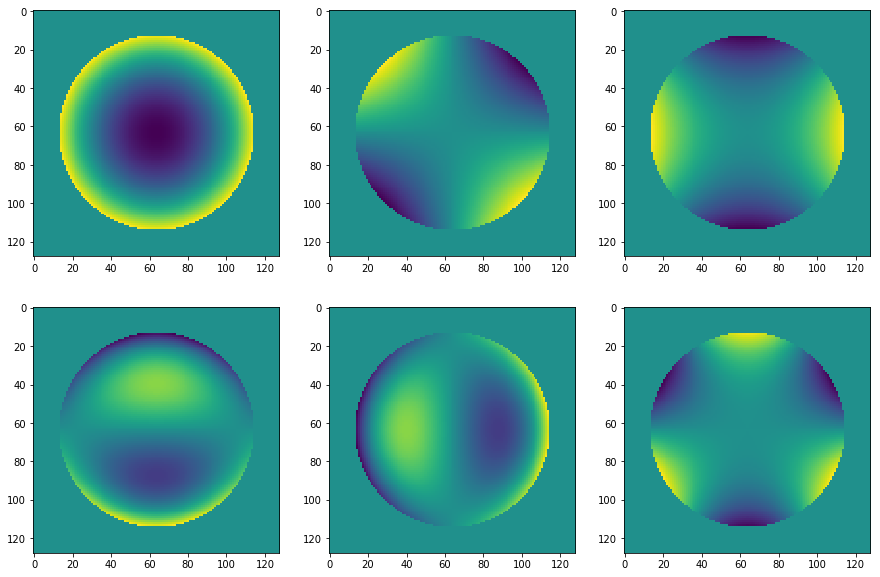

In [35]:
f, ax = pl.subplots(nrows=2, ncols=3, figsize=(15,10))
ax = ax.flatten()
for i in range(6):
    ax[i].imshow(deep_pd_network.zernikes_torch[i,:,:].cpu().numpy(), cmap=pl.cm.viridis)

Here is an example of a patch. The Fried radius is 24.5 cm and I show that the wavefront is decently recovered

16.073496
[ 0.873909   -1.6865215   0.02471897  0.04884362  0.13862488]
[ 0.6560399  -1.5726203   0.22083074  0.6568922  -0.57038033]


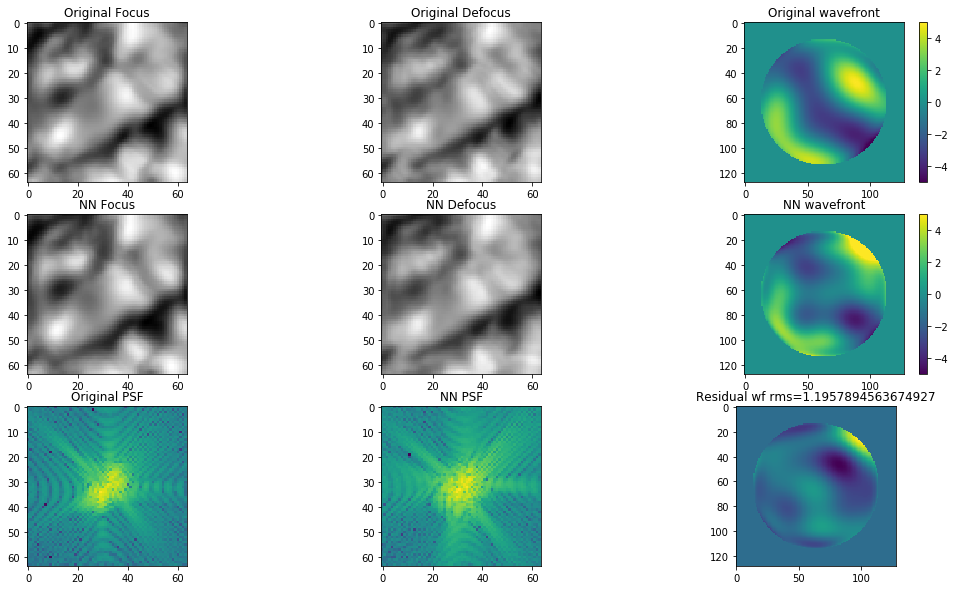

In [44]:
deep_pd_network.plot(index=2000)

In [50]:
interact_manual(deep_pd_network.plot, index=widgets.IntSlider(min=0,max=15000,step=1,value=10));

interactive(children=(IntSlider(value=10, description='index', max=15000), Button(description='Run Interact', …